Centroids:
 [[0.22861527 0.95602231 0.59067214 ... 0.28813022 0.13511936 0.3485043 ]
 [0.22854575 0.9584066  0.58999484 ... 0.28920119 0.1353417  0.34934629]
 [0.22882966 0.9508261  0.59205768 ... 0.28602051 0.13472171 0.34692973]
 ...
 [0.22856083 0.95781782 0.59016508 ... 0.2889294  0.13528397 0.34912984]
 [0.22850125 0.96078836 0.58928266 ... 0.2903581  0.13559748 0.35028884]
 [0.22851955 0.95961988 0.58963708 ... 0.28977829 0.13546727 0.34981215]]


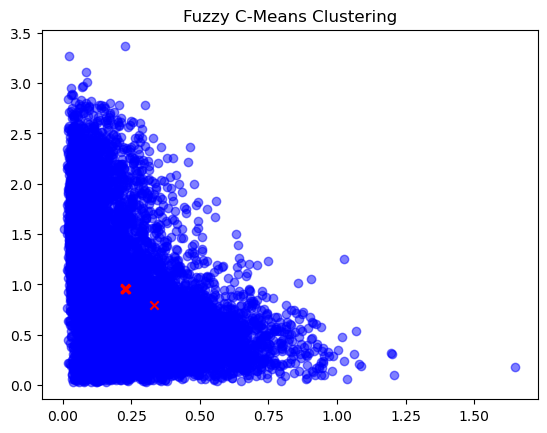

Initial GMM parameters:
Means:
 [[0.27103515 0.98132202 0.55796475 ... 0.10943622 0.02622648 0.25347505]
 [0.15483221 0.95658381 0.7096487  ... 0.3049119  0.11313437 0.53539151]
 [0.1971734  1.11925268 0.64760604 ... 0.57247931 0.231884   0.34075063]
 ...
 [0.45824458 0.64047044 0.41860357 ... 0.34244241 0.16335788 0.61558686]
 [0.39683869 0.66566558 0.49457662 ... 0.37284372 0.26667119 0.64058973]
 [0.13159261 2.02000882 0.3857975  ... 0.30876698 0.07858998 0.17218393]]
Covariances:
 [[[ 4.25392619e-02 -3.76582100e-02  2.85621255e-02 ... -3.72144280e-04
    2.53779877e-04  1.22460427e-02]
  [-3.76582100e-02  1.32791856e-01 -3.13643671e-02 ...  1.10597228e-03
   -7.01521406e-04 -2.09493585e-02]
  [ 2.85621255e-02 -3.13643671e-02  6.97118347e-02 ...  4.26284946e-04
    5.77366203e-04  2.17934339e-02]
  ...
  [-3.72144280e-04  1.10597228e-03  4.26284946e-04 ...  4.88080918e-03
    8.41010916e-04  2.78164678e-03]
  [ 2.53779877e-04 -7.01521406e-04  5.77366203e-04 ...  8.41010916e-04
    1

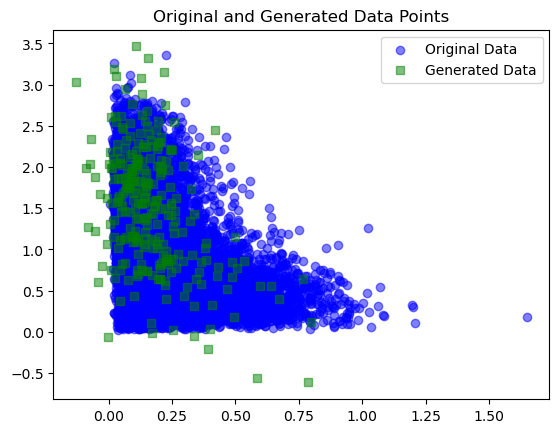

In [5]:
import torch
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

# Load pre-extracted MNIST features
features_path = 'imbalanced_train_features.pt'
features = torch.load(features_path).numpy()

# Step 2: Perform Fuzzy C-Means Clustering
n_clusters = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(features.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

# Print centroids
print("Centroids:\n", cntr)

# Plot the data and centroids
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x')
plt.title('Fuzzy C-Means Clustering')
plt.show()

# Step 3: Responsibility matrix is initialized (done during FCM)

# Step 4: Initialize GMM Parameters
def initialize_gmm_parameters(data, cntr, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, means_init=cntr)
    gmm.fit(data)
    return gmm

gmm = initialize_gmm_parameters(features, cntr, n_clusters)
mu = gmm.means_
sigma = gmm.covariances_

print("Initial GMM parameters:")
print("Means:\n", mu)
print("Covariances:\n", sigma)

# Step 5: Update means, covariance, and mixing coefficients 

# Step 6: Select all the 9 minority components (those with lower mixing coefficients)
mixing_coefficients = gmm.weights_
minority_indices = np.argsort(mixing_coefficients)[:9]  
print("Minority components indices:", minority_indices)

# Step 7: apply GMM for each minority cluster
def apply_gmm_to_minority(data, majority_data, minority_indices):
    gmm_params = {}
    for index in minority_indices:
        minority_data = data[np.argmax(u, axis=0) == index]
        if len(minority_data) < 2:  # Check if there are at least two samples
            continue
        m_comp = len(majority_data) / len(minority_data)
        n_components = max(1, int(np.round(m_comp)))  # Ensure n_components is at least 1
        gmm = GaussianMixture(n_components=n_components, init_params='kmeans')
        gmm.fit(minority_data)
        gmm_params[index] = (gmm.means_, gmm.covariances_, m_comp)
    return gmm_params

majority_class_indices = np.argmax(u, axis=0) == 0
majority_data = features[majority_class_indices]
gmm_params = apply_gmm_to_minority(features, majority_data, minority_indices)

# Step 8: Find k nearest neighbors among means for each element in minority classes
def find_k_nearest_neighbours(data, means, k):
    distances = cdist(data, means)
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]
    k_nearest_means = means[k_nearest_indices]
    return k_nearest_means

k = 3

# Step 9: Calculate mux and sigmax, and generate new elements
def generate_new_elements(minority_data, k_nearest_means, sigma, k, n_c):
    new_elements = []
    for x in minority_data:
        mux = (np.sum(k_nearest_means, axis=0) + x) / (k + 1)
        sigmax = (np.sum(sigma, axis=0) + np.cov(minority_data.T)) / (k + 1)
        new_elements.append(np.random.multivariate_normal(mux, sigmax, n_c))
    return np.vstack(new_elements)

new_elements = []

for index in minority_indices:
    minority_data = features[np.argmax(u, axis=0) == index]
    if len(minority_data) < 2:  
        continue
    means, covariances, m_comp = gmm_params[index]
    if m_comp >= k:
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = (len(majority_data) - len(minority_data)) // len(minority_data)
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
    else:
        n_comp = max(1, len(majority_data) // len(minority_data))  
        gmm = GaussianMixture(n_components=n_comp, init_params='kmeans')
        gmm.fit(minority_data)
        means, covariances = gmm.means_, gmm.covariances_
        new_elements_class = []
        n_c = max(1, len(minority_data) * (len(majority_data) // n_comp) // len(minority_data))  # Ensure n_c is at least 1
        for mean, cov in zip(means, covariances):
            new_elements_class.append(np.random.multivariate_normal(mean, cov, n_c))
        new_elements_class = np.vstack(new_elements_class)

    new_elements.append(new_elements_class)

new_elements = np.vstack(new_elements)

# Plotting original data and new generated elements
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5, label='Original Data')
plt.scatter(new_elements[:, 0], new_elements[:, 1], c='green', marker='s', alpha=0.5, label='Generated Data')
plt.title('Original and Generated Data Points')
plt.legend()
plt.show()


Centroids:
 [[0.22854957 0.95825702 0.59003813 ... 0.28913212 0.13532703 0.34929125]
 [0.22857555 0.95729481 0.59031443 ... 0.2886926  0.13523447 0.34894295]
 [0.22854396 0.95848585 0.5899716  ... 0.28923863 0.13534981 0.3493764 ]
 ...
 [0.2284953  0.96135108 0.58910792 ... 0.2906472  0.135664   0.35052992]
 [0.33125454 0.79747765 0.50576331 ... 0.38120843 0.19557731 0.52902644]
 [0.22852868 0.95916546 0.58977206 ... 0.28955981 0.13541934 0.34963492]]


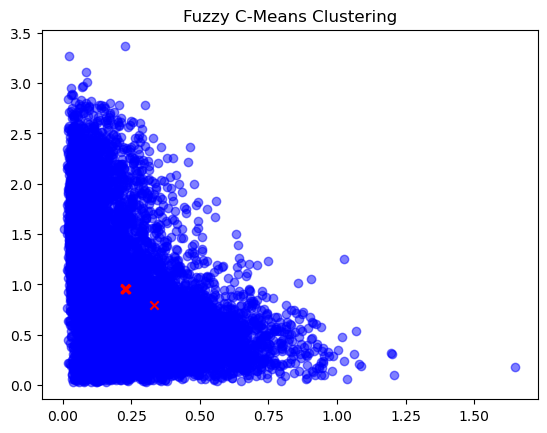

Initial GMM parameters:
Means:
 [[0.49832202 0.30175818 0.62496181 ... 0.10924228 0.06372258 0.23462997]
 [0.26081592 0.99678064 0.56672017 ... 0.11405412 0.02761308 0.25771074]
 [0.11959856 1.06087881 0.70989628 ... 0.30974334 0.12749455 0.41571525]
 ...
 [0.84072644 0.2889995  2.0364356  ... 0.13227084 0.05521161 0.20303524]
 [0.12280078 1.85951193 0.43942208 ... 0.2773507  0.07349061 0.20013004]
 [0.25494667 0.38145516 1.00670991 ... 0.12930797 0.11161987 0.430129  ]]
Covariances:
 [[[ 8.80760139e-02 -2.74273973e-03  2.53582897e-02 ... -6.98123871e-03
   -3.72904697e-03  6.82010426e-03]
  [-2.74273973e-03  1.90513500e-02 -4.64282476e-03 ... -5.57216740e-04
    1.76291186e-04  3.39097475e-03]
  [ 2.53582897e-02 -4.64282476e-03  5.73549524e-02 ... -4.06492657e-03
   -1.34065397e-03  1.37061844e-02]
  ...
  [-6.98123871e-03 -5.57216740e-04 -4.06492657e-03 ...  1.06249364e-02
    1.79268443e-03  1.84233043e-04]
  [-3.72904697e-03  1.76291186e-04 -1.34065397e-03 ...  1.79268443e-03
    2

In [3]:
import torch
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

# Load pre-extracted MNIST features
features_path = 'imbalanced_train_features.pt'
features = torch.load(features_path).numpy()

# Step 2: Perform Fuzzy C-Means Clustering
n_clusters = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(features.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

# Print centroids
print("Centroids:\n", cntr)

# Plot the data and centroids
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x')
plt.title('Fuzzy C-Means Clustering')
plt.show()

# Step 3: Responsibility matrix is initialized (done during FCM)

# Step 4: Initialize GMM Parameters
def initialize_gmm_parameters(data, cntr, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, means_init=cntr)
    gmm.fit(data)
    return gmm

gmm = initialize_gmm_parameters(features, cntr, n_clusters)
mu = gmm.means_
sigma = gmm.covariances_

print("Initial GMM parameters:")
print("Means:\n", mu)
print("Covariances:\n", sigma)

# Step 5: Update means, covariance, and mixing coefficients 

# Step 6: Select all the 9 minority components (those with lower mixing coefficients)
mixing_coefficients = gmm.weights_
minority_indices = np.argsort(mixing_coefficients)[:9]  
print("Minority components indices:", minority_indices)

# Step 7: Apply GMM for each minority cluster
def apply_gmm_to_minority(data, majority_data, minority_indices):
    gmm_params = {}
    for index in minority_indices:
        minority_data = data[np.argmax(u, axis=0) == index]
        if len(minority_data) < 2:  # Check if there are at least two samples
            continue
        m_comp = len(majority_data) / len(minority_data)
        n_components = max(1, int(np.round(m_comp)))  # Ensure n_components is at least 1
        gmm = GaussianMixture(n_components=min(n_components, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data)
        gmm_params[index] = (gmm.means_, gmm.covariances_, m_comp)
    return gmm_params

majority_class_indices = np.argmax(u, axis=0) == 0
majority_data = features[majority_class_indices]
gmm_params = apply_gmm_to_minority(features, majority_data, minority_indices)

# Step 8: Find k nearest neighbors among means for each element in minority classes
def find_k_nearest_neighbours(data, means, k):
    distances = cdist(data, means)
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]
    k_nearest_means = means[k_nearest_indices]
    return k_nearest_means

k = 3

# Step 9: Calculate mux and sigmax, and generate new elements
def generate_new_elements(minority_data, k_nearest_means, sigma, k, n_c):
    new_elements = []
    for x in minority_data:
        x = x.reshape(1, -1)
        mux = (np.sum(k_nearest_means, axis=1) + x) / (k + 1)
        sigmax = (np.sum(sigma, axis=0) + np.cov(minority_data.T)) / (k + 1)
        for mean in mux:
            new_elements.append(np.random.multivariate_normal(mean, sigmax, n_c))
    return np.vstack(new_elements)

new_elements = []

for index in minority_indices:
    minority_data = features[np.argmax(u, axis=0) == index]
    if len(minority_data) < 2:  
        continue
    means, covariances, m_comp = gmm_params[index]
    if m_comp >= k:
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, (len(majority_data) - len(minority_data)) // len(minority_data))
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements.append(new_elements_class)
    else:
        n_comp = max(1, len(majority_data) // len(minority_data))  
        gmm = GaussianMixture(n_components=min(n_comp, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data)
        means, covariances = gmm.means_, gmm.covariances_
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, len(minority_data) * (len(majority_data) // n_comp) // len(minority_data))
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements.append(new_elements_class)

new_elements = np.vstack(new_elements)

# Plotting original data and new generated elements
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5, label='Original Data')
plt.scatter(new_elements[:, 0], new_elements[:, 1], c='green', marker='s', alpha=0.5, label='Generated Data')
plt.title('Original and Generated Data Points')
plt.legend()
plt.show()


Centroids:
 [[0.22870007 0.95372601 0.59129868 ... 0.28716212 0.13492974 0.34776708]
 [0.2285361  0.95877858 0.58988732 ... 0.28937251 0.13537802 0.34948268]
 [0.22855796 0.95789318 0.5901445  ... 0.2889609  0.13529007 0.34915381]
 ...
 [0.22851309 0.95992824 0.58954574 ... 0.28992566 0.13549944 0.34993147]
 [0.22860903 0.95618517 0.59062788 ... 0.28819814 0.13513251 0.34855582]
 [0.22851247 0.9599648  0.58953473 ... 0.28994362 0.13550345 0.34994617]]


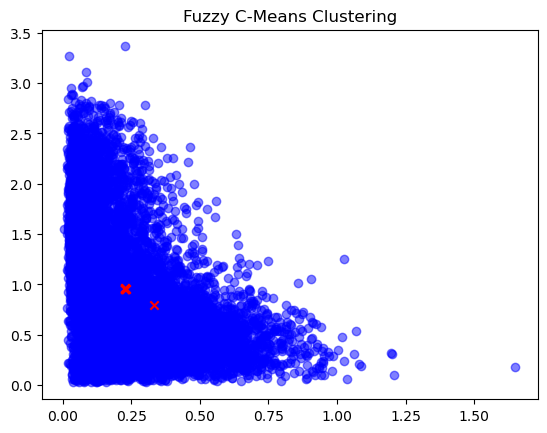

Initial GMM parameters:
Means:
 [[0.18599019 0.92086403 0.6475423  ... 0.33159735 0.13950358 0.5849262 ]
 [0.74688468 0.22109909 1.20848326 ... 0.10130482 0.1109824  0.38279014]
 [0.30945919 0.21986806 0.80906987 ... 0.30488349 0.27814465 0.29940274]
 ...
 [0.45736658 0.62674674 0.47971878 ... 0.38970419 0.25616637 0.63106867]
 [0.13293051 2.02394841 0.39472149 ... 0.3116318  0.07998013 0.1789739 ]
 [0.28167983 0.63695702 0.57779699 ... 0.28672016 0.15285563 0.40442521]]
Covariances:
 [[[ 1.12695346e-02 -3.06492849e-03  4.09884426e-03 ...  1.40253850e-03
    2.74943584e-03  2.79936683e-03]
  [-3.06492849e-03  6.09754575e-02 -5.93224377e-03 ... -1.55645823e-03
   -6.72923355e-03  2.30776419e-03]
  [ 4.09884426e-03 -5.93224377e-03  4.69041304e-02 ...  1.27200289e-02
    8.46386959e-03 -4.79975440e-03]
  ...
  [ 1.40253850e-03 -1.55645823e-03  1.27200289e-02 ...  3.15570920e-02
    1.21695796e-02 -8.70344630e-03]
  [ 2.74943584e-03 -6.72923355e-03  8.46386959e-03 ...  1.21695796e-02
    1

: 

In [1]:
import torch
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

# Load features
features_path = 'imbalanced_train_features.pt'
features = torch.load(features_path).numpy()

# Perform FCM
n_clusters = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(features.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

# Print centroids
print("Centroids:\n", cntr)

# Plot the data and centroids
plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5)
plt.scatter(cntr[:, 0], cntr[:, 1], c='red', marker='x')
plt.title('Fuzzy C-Means Clustering')
plt.show()

# Initialize GMM Parameters
def initialize_gmm_parameters(data, cntr, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, means_init=cntr)
    gmm.fit(data)
    return gmm

gmm = initialize_gmm_parameters(features, cntr, n_clusters)
mu = gmm.means_
sigma = gmm.covariances_

print("Initial GMM parameters:")
print("Means:\n", mu)
print("Covariances:\n", sigma)

# Select all the 9 minority components (those with lower mixing coefficients)
mixing_coefficients = gmm.weights_
minority_indices = np.argsort(mixing_coefficients)[:9]
print("Minority components indices:", minority_indices)

# Apply GMM for each minority cluster
def apply_gmm_to_minority(data, majority_data, minority_indices):
    gmm_params = {}
    for index in minority_indices:
        minority_data = data[np.argmax(u, axis=0) == index]
        if len(minority_data) < 2:
            continue
        m_comp = len(majority_data) / len(minority_data)
        n_components = max(1, int(np.round(m_comp)))
        gmm = GaussianMixture(n_components=min(n_components, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data)
        gmm_params[index] = (gmm.means_, gmm.covariances_, m_comp)
    return gmm_params

majority_class_indices = np.argmax(u, axis=0) == 0
majority_data = features[majority_class_indices]
gmm_params = apply_gmm_to_minority(features, majority_data, minority_indices)

def find_k_nearest_neighbours(data, means, k):
    distances = cdist(data, means)
    k_nearest_indices = np.argsort(distances, axis=1)[:, :k]
    k_nearest_means = means[k_nearest_indices]
    return k_nearest_means

k = 3

def generate_new_elements(minority_data, k_nearest_means, sigma, k, n_c):
    mux = (np.sum(k_nearest_means, axis=1) + minority_data[:, np.newaxis, :]) / (k + 1)
    sigmax = (np.sum(sigma, axis=0) + np.cov(minority_data.T)) / (k + 1)
    new_elements = np.vstack([np.random.multivariate_normal(mean, sigmax, n_c) for mean in mux.reshape(-1, mux.shape[-1])])
    return new_elements

new_elements_list = []

for index in minority_indices:
    minority_data = features[np.argmax(u, axis=0) == index]
    if len(minority_data) < 2:
        continue
    means, covariances, m_comp = gmm_params[index]
    if m_comp >= k:
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, (len(majority_data) - len(minority_data)) // len(minority_data))
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements_list.append(new_elements_class)
    else:
        n_comp = max(1, len(majority_data) // len(minority_data))
        gmm = GaussianMixture(n_components=min(n_comp, len(minority_data)), init_params='kmeans')
        gmm.fit(minority_data)
        means, covariances = gmm.means_, gmm.covariances_
        k_nearest_means = find_k_nearest_neighbours(minority_data, means, k)
        n_c = max(1, len(minority_data) * (len(majority_data) // n_comp) // len(minority_data))
        new_elements_class = generate_new_elements(minority_data, k_nearest_means, covariances, k, n_c)
        new_elements_list.append(new_elements_class)

new_elements = np.vstack(new_elements_list)

plt.scatter(features[:, 0], features[:, 1], c='blue', marker='o', alpha=0.5, label='Original Data')
plt.scatter(new_elements[:, 0], new_elements[:, 1], c='green', marker='s', alpha=0.5, label='Generated Data')
plt.title('Original and Generated Data Points')
plt.legend()
plt.show()
